In [1]:
# to reproduce the figures in the paper
apache_test_run = "20250112_23_11"
gnome_test_run = "20250113_00_07"

# to generate figures for newly measured data, comment out the two lines above and uncomment the following:
#apache_test_run = "apache_latest"
#gnome_test_run = "gnome_latest"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import matplotlib.ticker as ticker

def read_testcase(file):
    scenario_name = file.split('/')[-1].replace('.log', '')
    try:
        df = pd.read_csv(file, header=None, skiprows=5) # skip first five runs (warmup)
        df.columns = ['kernel', 'initrd', 'user', 'sum', 'graphical']
        df = df.map(lambda value: float(value.rstrip('ms'))*1000 if value.endswith('ms') else float(value.rstrip('s')))
    except:
        df = pd.DataFrame(columns=['kernel', 'initrd', 'user', 'sum', 'graphical'])
    df.insert(0, 'testcase', scenario_name)
    return df

def read_all_testcases(base_dir):
    files = glob.glob(f"{base_dir}/*.log")
    df = pd.concat([read_testcase(file) for file in files])
    
    base_case = df[df['testcase'].str.count('_') == 1].copy() # e.g. xfs_apache
    cipher_cases = df[df['testcase'].str.count('_') == 2].copy() # e.g. xfs_mldsa44_apache
    base_case[['fs', 'app']] = base_case['testcase'].str.split('_', expand=True)
    base_case['cipher'] = 'none'
    base_case.drop(columns=['testcase'], inplace=True)
    cipher_cases[['fs', 'cipher', 'app']] = cipher_cases['testcase'].str.split('_', expand=True)
    cipher_cases.drop(columns=['testcase'], inplace=True)
    df = pd.concat([base_case, cipher_cases])
    return df

def fix_names(df):
    df['cipher'] = df['cipher'].str.replace('sphincs', 'S', regex=True)
    df['cipher'] = df['cipher'].str.replace('simple', '', regex=True)
    df['cipher'] = df['cipher'].str.replace('prime256v1', 'ecdsa-p256', regex=True)
    df['cipher'] = df['cipher'].str.replace('rsa-4096', 'rsa4096', regex=True)
    df['cipher'] = df['cipher'].str.replace('lms', '', regex=True)
    return df

3850
3849


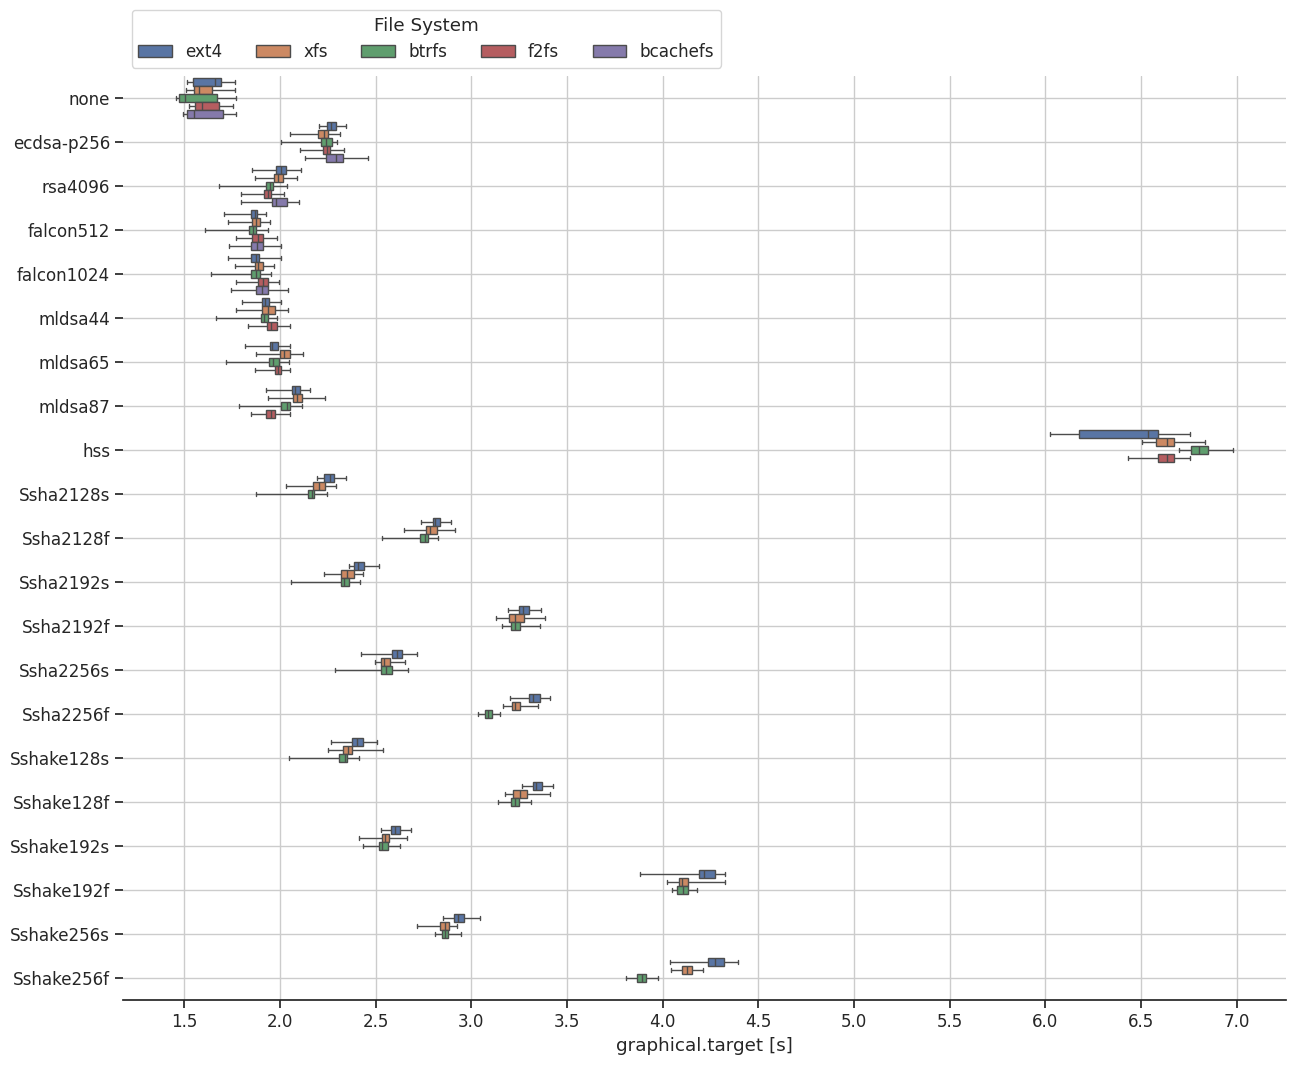

In [3]:
def boxplot_grouped(df, col, xlim=[1,8], tick=0.2):
    order = [
        'none',
        'ecdsa-p256',
        'rsa4096',
        'falcon512',
        'falcon1024',
        'mldsa44',
        'mldsa65',
        'mldsa87',
        'hss',
        'Ssha2128s', 
        'Ssha2128f',
        'Ssha2192s', 
        'Ssha2192f', 
        'Ssha2256s', 
        'Ssha2256f',
        'Sshake128s',
        'Sshake128f', 
        'Sshake192s',
        'Sshake192f',
        'Sshake256s',
        'Sshake256f'
    ]

    fs_order = ['ext4', 'xfs', 'btrfs', 'f2fs', 'bcachefs']

    print(len(df))
    stds = df.groupby(['cipher','fs'])[col].transform('std').rename('std')
    means = df.groupby(['cipher','fs'])[col].transform('mean').rename('mean')
    mins = means - 5*stds
    maxs = means + 5*stds
    df = df[(df[col] > mins) & (df[col] < maxs)]
    print(len(df))
    
    sns.set_theme(style="ticks", font_scale=1.1)
    f, ax = plt.subplots(figsize=(15,12))
    g = sns.boxplot(df, ax=ax, x=col, y="cipher", hue="fs", whis=[0, 100], width=0.9, order=order, hue_order=fs_order)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set(ylabel="")
    ax.set(xlabel="graphical.target [s]")
    sns.despine(trim=False, left=True)

    g.legend_.set_title('File System')
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.0, 1.0), ncols=5, title='File System')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick))
    return f

value = 'graphical'

df_apache = fix_names(read_all_testcases(f'../measurements/{apache_test_run}'))
fig_apache = boxplot_grouped(df_apache, value, xlim=[1.4,7.3], tick=0.5)
fig_apache.savefig("boot_apache.pdf", format="pdf", bbox_inches="tight")

3850
3844


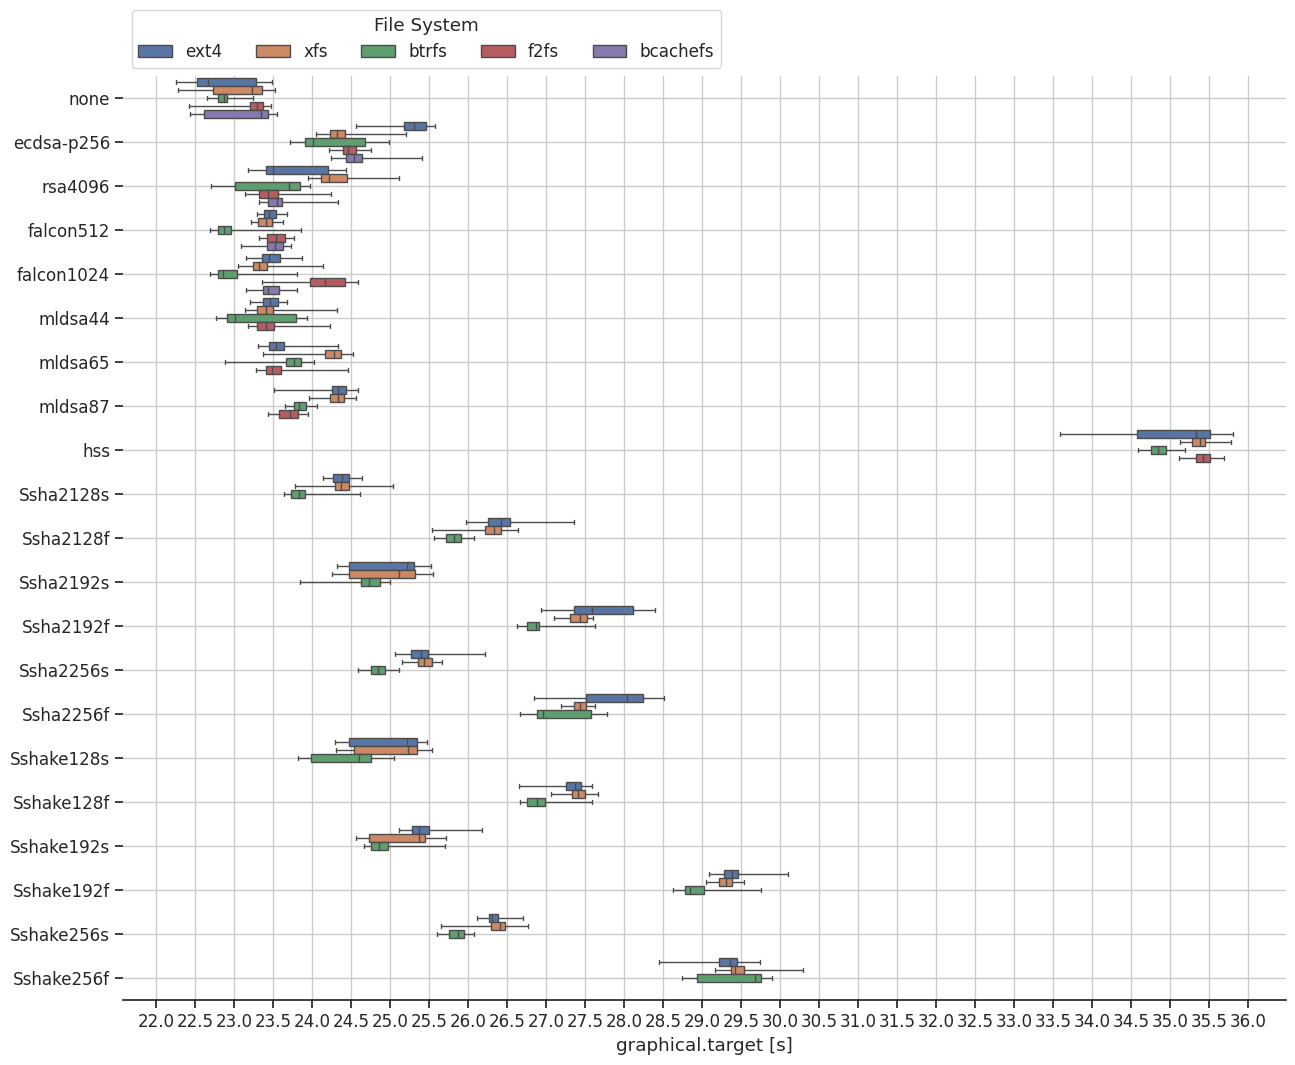

In [4]:
df_gnome = fix_names(read_all_testcases(f'../measurements/{gnome_test_run}'))
fig_gnome = boxplot_grouped(df_gnome, 'graphical', xlim=[22,36], tick=0.5)
fig_gnome.savefig("boot_gnome.pdf", format="pdf", bbox_inches="tight")